In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [161]:
df = pd.read_csv("data\consumption_temp.csv")
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'hel'}, xlabel='time'>

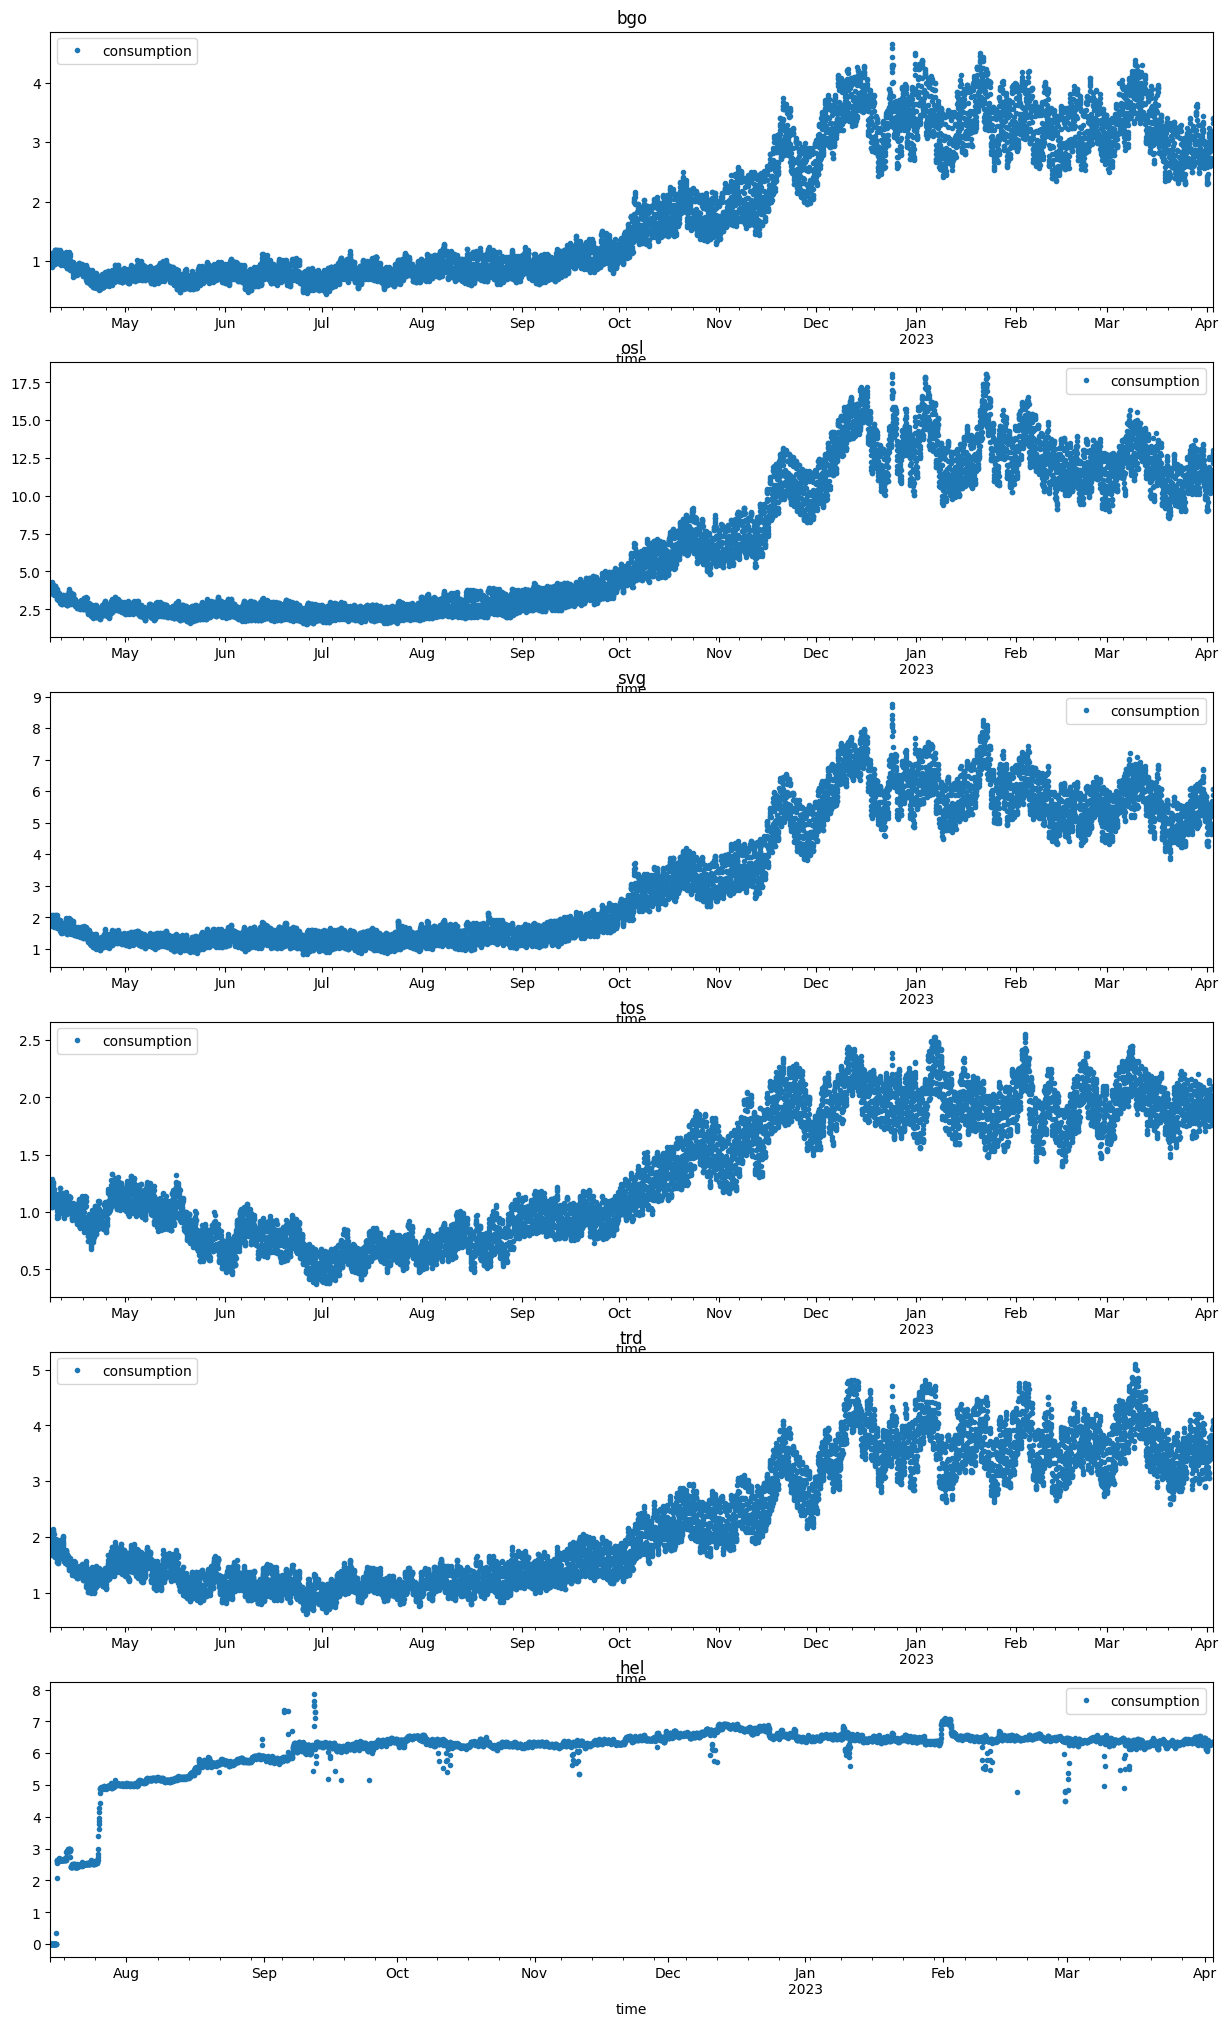

In [162]:
bgo = df.query('location == "bergen"')
osl = df.query('location == "oslo"')
svg = df.query('location == "stavanger"')
tos = df.query('location == "tromsø"')
trd = df.query('location == "trondheim"')
hel = df.query('location == "helsingfors"')

locations = [bgo, osl, svg, tos, trd, hel]

fig, axs = plt.subplots(6, 1, figsize=(15,25), sharex=False)
bgo[["consumption", ]].plot(ax=axs[0], title="bgo", style=".")
osl[["consumption",]].plot(ax=axs[1], title="osl", style=".")
svg[["consumption",]].plot(ax=axs[2], title="svg", style=".")
tos[["consumption", ]].plot(ax=axs[3], title="tos", style=".")
trd[["consumption",]].plot(ax=axs[4], title="trd", style=".")
hel[["consumption", ]].plot(ax=axs[5], title="hel", style=".")


## Simple train/test split

In [163]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Creating daily lag features for up to 3 days
    for lag in range(24, 24*3+1, 24):
        df['lag_daily_' + str((lag))] = df['consumption'].shift(lag)
    # Rolling standard deviation
    df['rolling_std_1d'] = df['consumption'].rolling(window=24).std()
    
    # create lagged target
    df["lagged_consumption"] = df["consumption"].shift(-120)
    df.dropna(subset=['lagged_consumption'],inplace=True)
    return df

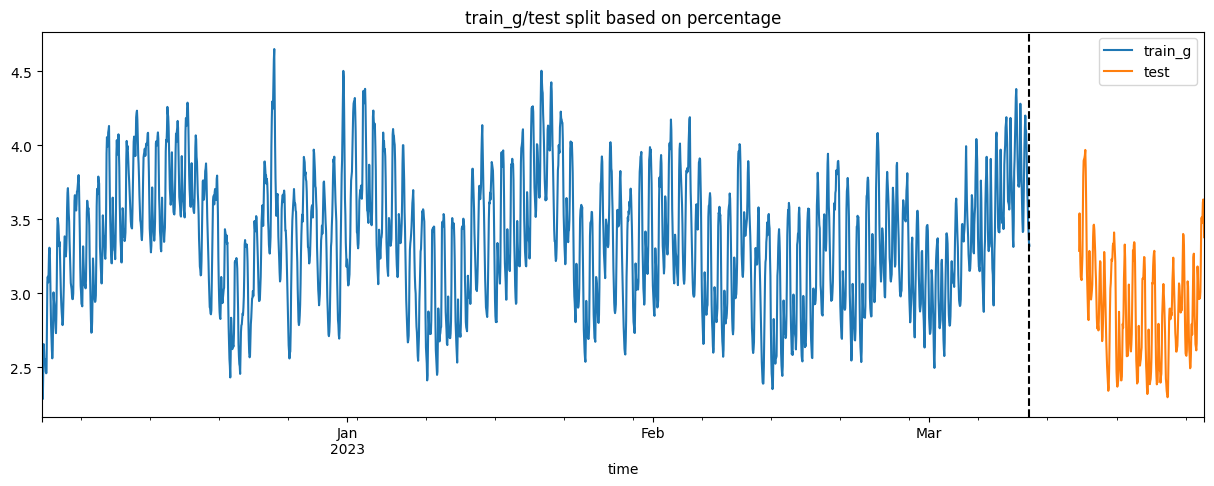

In [164]:
# only use 2023 data
bgo = bgo.query('time > "12-2022"')
bgo = create_features(bgo)

# Determine the split point
split_idx = int(len(bgo) * 0.85)

# Split the data
train_g = bgo.iloc[:split_idx]
test_split_idx = split_idx + 24*5
test = bgo.iloc[test_split_idx:]

# Plot the data
fig, ax = plt.subplots(figsize=(15,5))
train_g["consumption"].plot(ax=ax, label="train_g", title="train_g/test split based on percentage")
test["consumption"].plot(ax=ax, label="test")
ax.axvline(train_g.index[-1], color="black", ls="--")
ax.legend(["train_g", "test"])
plt.show()


In [165]:
### Check if split is right
display(train_g.tail())
display(test.head())

,location,consumption,temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_daily_24,lag_daily_48,lag_daily_72,rolling_std_1d,lagged_consumption
time,,,,,,,,,,,,,,,,
2023-03-11 00:00:00,bergen,3.589445,-2.7,0,5,1,3,2023,70,11,10,3.813210,3.621181,3.443949,0.248415,3.097224
2023-03-11 01:00:00,bergen,3.467924,-3.1,1,5,1,3,2023,70,11,10,3.723595,3.611564,3.416319,0.258680,3.073956
2023-03-11 02:00:00,bergen,3.413340,-3.2,2,5,1,3,2023,70,11,10,3.732026,3.599150,3.419431,0.271499,3.040196
2023-03-11 03:00:00,bergen,3.341153,-2.7,3,5,1,3,2023,70,11,10,3.720530,3.566089,3.411542,0.287581,2.987902
2023-03-11 04:00:00,bergen,3.321834,-3.3,4,5,1,3,2023,70,11,10,3.762313,3.615926,3.481033,0.303409,3.064918


,location,consumption,temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_daily_24,lag_daily_48,lag_daily_72,rolling_std_1d,lagged_consumption
time,,,,,,,,,,,,,,,,
2023-03-16 05:00:00,bergen,3.287060,-3.9,5,3,1,3,2023,75,16,11,3.214549,3.232250,3.196921,0.315696,2.812684
2023-03-16 06:00:00,bergen,3.540023,-2.5,6,3,1,3,2023,75,16,11,3.541954,3.499497,3.452659,0.315592,3.059199
2023-03-16 07:00:00,bergen,3.371523,-0.9,7,3,1,3,2023,75,16,11,3.337618,3.335736,3.342396,0.316537,2.872217
2023-03-16 08:00:00,bergen,3.205564,1.1,8,3,1,3,2023,75,16,11,3.132470,3.102492,3.244052,0.316687,2.755842
2023-03-16 09:00:00,bergen,3.110050,2.7,9,3,1,3,2023,75,16,11,2.952252,2.934810,3.204428,0.313907,2.677296


<Axes: title={'center': 'One week of data'}, xlabel='time'>

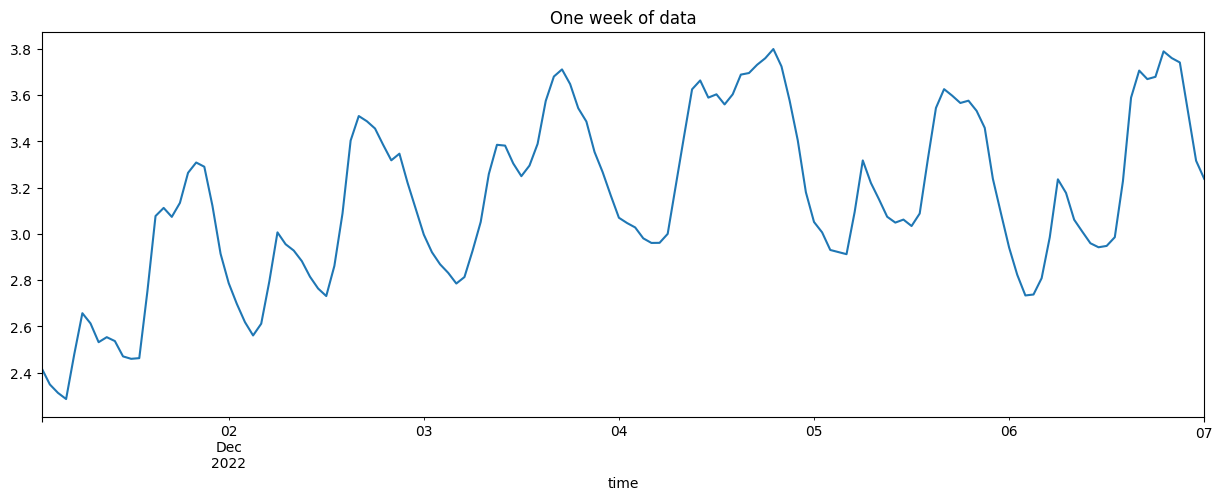

In [166]:
bgo.loc[(bgo.index > "12-01-2022") & (bgo.index <= "12-07-2022")]["consumption"].plot(
    figsize=(15,5), title="One week of data"
)

## Cross Validation split

In [167]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=589, gap=24*5)
tss

TimeSeriesSplit(gap=120, max_train_size=None, n_splits=3, test_size=589)

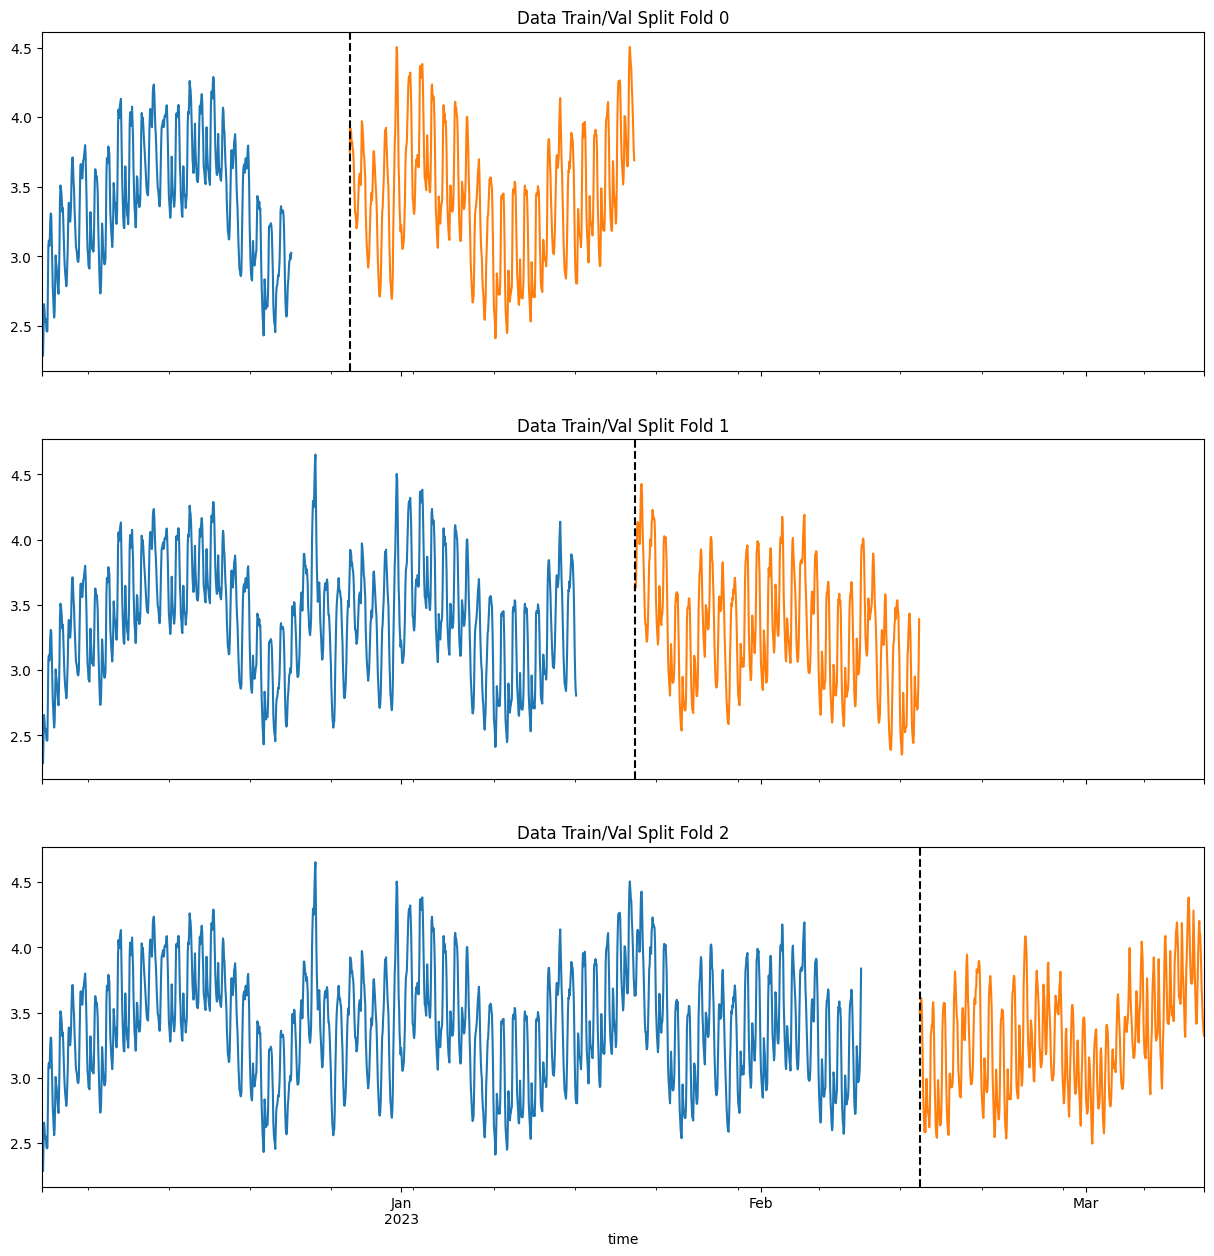

In [168]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train_g):
    train = train_g.iloc[train_idx]
    val = train_g.iloc[val_idx]
    train['consumption'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Val Split Fold {fold}')
    val['consumption'].plot(ax=axs[fold],
                         label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Model Creation

## Train Using Cross-Validation

In [169]:

FEATURES = ["hour", "dayofyear", "temperature", "lag_daily_24", "rolling_std_1d", ]
TARGET = 'lagged_consumption'

In [170]:
tss = TimeSeriesSplit(n_splits=3, test_size=589, gap=24*5)
train_g = train_g.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_g):
    train = train_g.iloc[train_idx]
    val = train_g.iloc[val_idx]

#     train = create_features(train)
#     val = create_features(val)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=200)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:2.97257	validation_1-rmse:2.92399
[200]	validation_0-rmse:0.44912	validation_1-rmse:0.46709
[315]	validation_0-rmse:0.19977	validation_1-rmse:0.43517
[0]	validation_0-rmse:2.94348	validation_1-rmse:2.74031
[200]	validation_0-rmse:0.47008	validation_1-rmse:0.31236
[267]	validation_0-rmse:0.29958	validation_1-rmse:0.33764
[0]	validation_0-rmse:2.89698	validation_1-rmse:2.85654
[200]	validation_0-rmse:0.47757	validation_1-rmse:0.54461
[396]	validation_0-rmse:0.22330	validation_1-rmse:0.38398


In [171]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.3675
Fold scores:[0.41741886611448376, 0.3021923827284807, 0.3829476349937596]


## Feature Importance

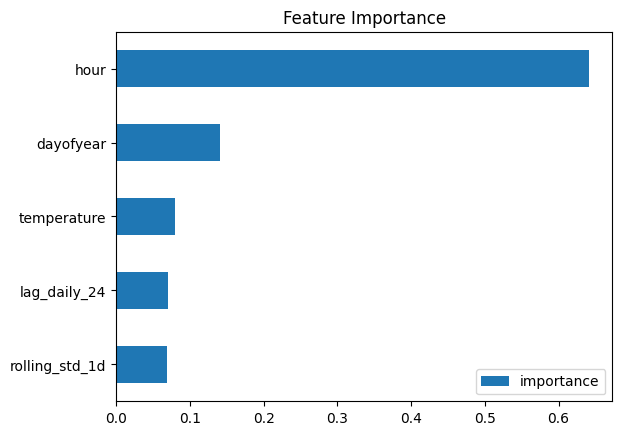

In [172]:

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Predicting on The Test Set

In [173]:
# test = create_features(test)
test.query('hour == 2')

,location,consumption,temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_daily_24,lag_daily_48,lag_daily_72,rolling_std_1d,lagged_consumption
time,,,,,,,,,,,,,,,,
2023-03-17 02:00:00,bergen,2.919367,3.7,2,4,1,3,2023,76,17,11,3.040196,3.018425,3.010532,0.356459,2.390027
2023-03-18 02:00:00,bergen,2.759935,-1.6,2,5,1,3,2023,77,18,11,2.919367,3.040196,3.018425,0.223238,2.361987
2023-03-19 02:00:00,bergen,2.445723,5.0,2,6,1,3,2023,78,19,11,2.759935,2.919367,3.040196,0.232738,2.384770
2023-03-20 02:00:00,bergen,2.369071,2.1,2,0,1,3,2023,79,20,12,2.445723,2.759935,2.919367,0.391470,2.340943
2023-03-21 02:00:00,bergen,2.583487,-0.1,2,1,1,3,2023,80,21,12,2.369071,2.445723,2.759935,0.282040,2.605855
2023-03-22 02:00:00,bergen,2.390027,4.8,2,2,1,3,2023,81,22,12,2.583487,2.369071,2.445723,0.302769,2.577724
2023-03-23 02:00:00,bergen,2.361987,3.3,2,3,1,3,2023,82,23,12,2.390027,2.583487,2.369071,0.297607,2.614430
2023-03-24 02:00:00,bergen,2.384770,4.3,2,4,1,3,2023,83,24,12,2.361987,2.390027,2.583487,0.341761,2.761343
2023-03-25 02:00:00,bergen,2.340943,4.4,2,5,1,3,2023,84,25,12,2.384770,2.361987,2.390027,0.232341,2.596086


In [174]:

X_test = test[FEATURES]
y_test = test[TARGET]

In [175]:
# reg = xgb.XGBRegressor(booster='gbtree',    
#                        n_estimators=1000,
#                        early_stopping_rounds=50,
#                        objective='reg:squarederror',
#                        max_depth=3,
#                        learning_rate=0.01,
#                        subsample=0.8,
#                        )
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         verbose=100)

C:\Users\elias\AppData\Local\Temp\ipykernel_5968\1557730646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)
C:\Users\elias\AppData\Local\Temp\ipykernel_5968\1557730646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['shifted_prediction'] = test['prediction'].shift(120)


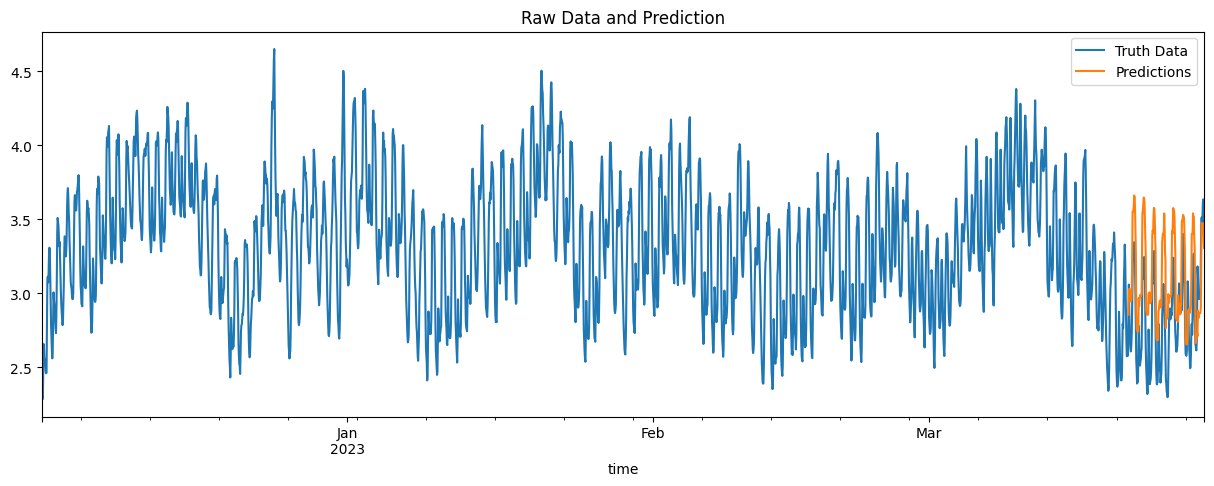

In [176]:
test['prediction'] = reg.predict(X_test)
test['shifted_prediction'] = test['prediction'].shift(120)
test[test.hour == 12]
bgo = bgo.merge(test[['shifted_prediction']], how='left', left_index=True, right_index=True)
ax = bgo[['consumption']].plot(figsize=(15, 5), style="-")
bgo['shifted_prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

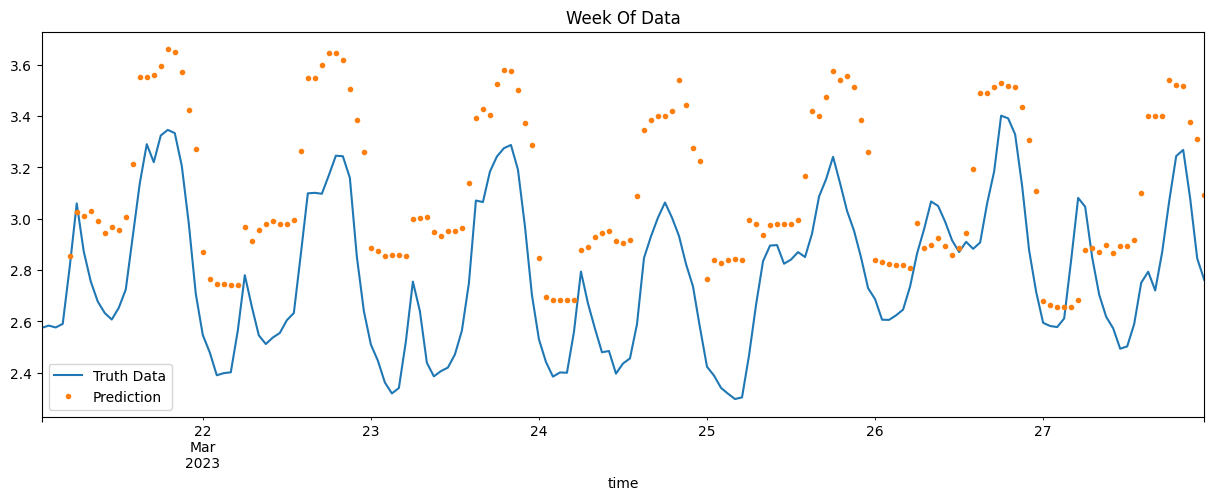

In [177]:
ax = bgo.loc[(bgo.index > '03-21-2023') & (bgo.index < '03-28-2023')]['consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '03-21-2023') & (bgo.index < '03-28-2023')]['shifted_prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

ax = bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['consu'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [182]:
score = np.sqrt(mean_squared_error(test['consumption'], test['shifted_prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

ValueError: Input contains NaN.

In [179]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-03-18    0.409438
2023-03-19    0.400523
2023-03-17    0.388046
2023-03-26    0.374793
2023-03-27    0.363997
2023-03-20    0.363561
2023-03-22    0.299785
2023-03-16    0.296393
2023-03-24    0.292462
2023-03-21    0.205761
Name: error, dtype: float64